In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load dataset and variable documentation
df = pd.read_csv("3-cell2cell.csv")
doc_df = pd.read_csv("3-Cell2Cell+Data+Documentation.csv", skiprows=5)

In [6]:
df.head()

,customer,calibrat,churn,churndep,revenue,mou,recchrge,directas,overage,roam,...,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
0,1000002,0,0,NaN,57.492500,482.75,37.424999,0.2475,22.75,0.0,...,0,0,1,0,0,5,0,0,149.989990,0
1,1000006,0,0,NaN,82.275002,1312.25,75.000000,1.2375,0.00,0.0,...,0,1,0,0,0,6,0,0,9.989998,0
2,1000010,0,0,NaN,31.662500,25.50,29.990000,0.2475,0.00,0.0,...,0,0,1,0,0,9,0,0,29.989990,0
3,1000011,0,0,NaN,62.127499,97.50,65.985001,2.4750,0.00,0.0,...,0,1,0,0,0,6,0,0,29.989990,0
4,1000014,0,0,NaN,25.225000,2.50,25.000000,0.0000,0.00,0.0,...,0,1,0,0,0,7,0,0,29.989990,0


In [8]:
# Step 2: Clean variable documentation
doc_df.columns = [
    "Position", "Variable Name", "Blank1", "Description",
    "N", "Minimum", "Maximum", "Mean", "StdDev", "Blank2", "Notes"
]
doc_df = doc_df[["Variable Name", "Description", "StdDev"]].dropna(subset=["Variable Name", "StdDev"])
doc_df["StdDev"] = pd.to_numeric(doc_df["StdDev"], errors="coerce").dropna()

In [20]:
# Step 3: Build model using calibration data
predictors = df.columns[4:]
calibration_df = df[df["churndep"].notna()].copy()

# Special case: two variables that use zero as missing value
calibration_df["income"] = calibration_df["income"].replace(0, np.nan)
calibration_df["setprc"] = calibration_df["setprc"].replace(0, np.nan)

# Use median imputation
X_calibration = calibration_df[predictors].fillna(calibration_df[predictors].median())
y_calibration = calibration_df["churndep"]

# Scale the input variables to the first and second moments
scaler = StandardScaler()
scaler.fit(X_calibration)

log_model = sm.Logit(y_calibration, sm.add_constant(scaler.transform(X_calibration))).fit()

Optimization terminated successfully.
         Current function value: 0.670851
         Iterations 6


In [22]:
# Step 4: Economic importance summary
summary_df = pd.DataFrame({
    "Variable": ['constant'] + list(predictors),
    "Coefficient": [round(p, ndigits=4) for p in log_model.params],
    "Odds Ratio": [round(np.exp(val), ndigits=2) for val in log_model.params],
    "Importance": [abs(val) for val in log_model.params],
    "P-value": list(log_model.pvalues)
})

significance = 0.05
summary_df = summary_df.dropna(
).where(
    summary_df["P-value"] < significance
).sort_values(
    "Importance", ascending=False
)

print("Top 10 Predictors by Economic Importance:\n")
print(summary_df.head(10))

summary_df.to_csv('economic_importance.csv')

Top 10 Predictors by Economic Importance:

    Variable  Coefficient  Odds Ratio  Importance       P-value
27   eqpdays       0.3794        1.46    0.379364  1.203498e-89
23  uniqsubs       0.2433        1.28    0.243299  6.390022e-21
22    months      -0.2111        0.81    0.211082  8.608740e-29
66   retcall       0.1504        1.16    0.150415  6.130350e-05
2        mou      -0.1382        0.87    0.138176  6.299077e-08
24  actvsubs      -0.1338        0.87    0.133764  9.507663e-13
7    changem      -0.1247        0.88    0.124669  6.491707e-20
9    dropvce       0.1195        1.13    0.119498  1.902446e-02
32  creditaa      -0.1112        0.89    0.111155  4.025774e-24
1    revenue       0.0973        1.10    0.097275  4.571511e-03


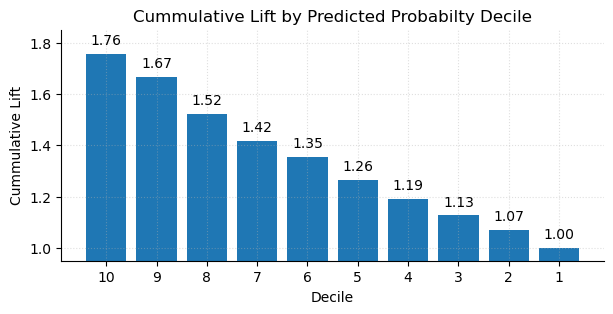

In [24]:
# Step 5: Validate model and build lift chart
validation_df = df[df["churndep"].isna()].copy()

# Same pipeline: Impute and scale with calibration dataset statistics
validation_df["income"] = validation_df["income"].replace(0, np.nan)
validation_df["setprc"] = validation_df["setprc"].replace(0, np.nan)
X_validation = validation_df[predictors].fillna(X_calibration.median())
validation_df["predicted_prob"] = log_model.predict(
    sm.add_constant(scaler.transform(X_validation))
)

# Sort predictions by decile
quantile_count = 10
validation_df["decile"] = pd.qcut(
    validation_df["predicted_prob"],
    quantile_count,
    labels=False,
    duplicates="drop"
)
lift_chart = validation_df.groupby("decile")["churn"].agg(["count", "sum"])
lift_chart = lift_chart.sort_index(ascending=False).reset_index()

# Calculate cummulative lift in predicting churn by decile
lift_chart["cummulative_churn_rate"] = lift_chart["sum"].cumsum() / lift_chart["count"].cumsum()
baseline_churn = validation_df["churn"].mean()
lift_chart["cummulative_lift"] = lift_chart["cummulative_churn_rate"] / baseline_churn

# Plot the cummulative lift
plt.figure(figsize=(7,3))
plt.bar(range(quantile_count), lift_chart['cummulative_lift'])
plt.xticks(range(quantile_count), (lift_chart['decile'] + 1).astype(str))
plt.xlabel("Decile")
plt.ylabel("Cummulative Lift")
plt.title("Cummulative Lift by Predicted Probabilty Decile")
ax = plt.gca()
for i, y_val in enumerate(lift_chart['cummulative_lift']):
    ax.text(i, y_val + 0.025, f"{y_val:.2f}", ha='center', va='bottom')

ax.spines[['right', 'top']].set_visible(False)
plt.ylim(0.95, 1.85)
plt.grid(alpha=0.4, linestyle=':')
plt.show()

In [26]:
# Step 6: LTV estimation by revenue segment
def calculate_ltv(monthly_revenue, monthly_churn, discount_rate=0.10, years=1):
    # Assume all churn occurs at the beginning of each month
    stay_factor = 1 - monthly_churn
    staying_probs = np.array([stay_factor ** i for i in range(1, years * 12 + 1)])

    # Assume revenue is collected at the end of each month
    monthly_discount = (1 + discount_rate) ** (1/12)
    discount_factors = np.array([1 / monthly_discount ** i for i in range(1, years * 12 + 1)])

    # Assume constant monthly revenue
    monthly_profits = monthly_revenue * staying_probs * discount_factors
    return np.sum(monthly_profits)

top_decile = validation_df[validation_df["decile"] == 9].copy()
revenue_bins = [0, 30, 50, 70, 90, np.inf]
revenue_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
top_decile["revenue_segment"] = pd.cut(top_decile["revenue"], bins=revenue_bins, labels=revenue_labels)

segment_stats = top_decile.groupby("revenue_segment").agg(
    avg_revenue=("revenue", "mean"),
    customer_count=("customer", "count"),
    churn_rate=("churn", "mean")
).reset_index()

segment_stats["baseline_ltv"] = segment_stats["avg_revenue"].apply(
    lambda x: calculate_ltv(x, baseline_churn)
)
#=============================================================================#
# Our core assumption: reducing churn by 50%
churn_reduction_percent = 50.0
#=============================================================================#
segment_stats["improved_ltv"] = segment_stats.apply(
    lambda row: calculate_ltv(row["avg_revenue"],
        (row["churn_rate"] * (1 - churn_reduction_percent / 100))),
        axis=1
)
segment_stats["ltv_improvement"] = segment_stats["improved_ltv"] - segment_stats["baseline_ltv"]
segment_stats["max_incentive"] = segment_stats["ltv_improvement"]
segment_stats['customer_count'] /= len(top_decile)
segment_stats.drop(['ltv_improvement'], axis=1, inplace=True)
segment_stats.columns = ['Segment',
                         'Avg Revenue',
                         '% Customers',
                         'Churn Rate',
                         'Baseline LTV',
                         'Improved LTV',
                         'Max Incentive'
                        ]
currencies = ['Avg Revenue', 'Baseline LTV', 'Improved LTV', 'Max Incentive']
percentages = ['Churn Rate', '% Customers']

for colname in currencies:
  string_series = segment_stats[colname].round().astype(str)
  segment_stats[colname] = ['(-$'+s[1:-2]+')' if s[0]=='-' else '$'+s[:-2] for s in string_series]

for colname in percentages:
  segment_stats[colname] = (100 * segment_stats[colname]).round(2).astype(str) + '%'


print("\nLTV and Incentive by Revenue Segment:")
print(segment_stats)

segment_stats.to_csv('ltv_improvement.csv')


LTV and Incentive by Revenue Segment:
     Segment Avg Revenue % Customers Churn Rate Baseline LTV Improved LTV  \
0   Very Low         $19      24.64%       3.4%         $194         $197   
1        Low         $37      35.14%      3.48%         $375         $380   
2     Medium         $58      15.43%      2.71%         $583         $605   
3       High         $79       7.44%       3.9%         $797         $797   
4  Very High        $187      16.91%      3.81%        $1883        $1889   

  Max Incentive  
0            $3  
1            $5  
2           $23  
3            $1  
4            $7  
